# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:
import torch
%load_ext autoreload
%autoreload 2

from sys import platform
from utilities import *
from IPython.display import display

from functools import partial
import warnings

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier
from models.bertOne import BertOne

from DrTorch.utilities import DataLoaderFromPipelineStrategy
from DrTorch.utilities import plot_history
from DrTorch.metrics import MultyHeadMetric, F1_Score, Accuracy, Recall, Precision
from DrTorch.callbacks import EarlyStopper
from DrTorch.wrappers import OptimizerWrapper,Criterion, MultyHeadCriterion


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device == 'cuda':
    !nvidia-smi


## Defining flags and variables

In [4]:
# warning ignore
warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
warnings.filterwarnings("ignore", message="overflow encountered in scalar add")

##### PATHS AND DIRECTORY

DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

# Directory paths for model and result storage
BERT_DIRECTORY = "local-bert"
RESULT_DIRECTORY = 'results'  # Directory to store the results
GRID_DIRECTORY = 'grid'  # Directory to store the grid results
WEIGHTS_DIRECTORY = 'weights'  # Directory to store model weights

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 

# File paths for grid search results
FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'freezed_bertone_grid_search_results.pkl')
FULL_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'full_bertwo_grid_search_results.pkl')

# File paths for model weights
FREEZED_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'freezed_bertone_weights.pth')
FULL_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'full_bertone_weights.pth')

# BERT HIDDEN DIMENSION
BERT_HIDDEN_DIM = 768 # bert hidden dimension 
PATIENCE = 3 #Patience of the early stoppers


##### FLAGS FOR MODEL TRAINING AND EVALUATION

# Flags for running additional classifiers
RUN_RANDOM_CLF = True
RUN_MAJORITY_CLF = True

# Flags for fitting different BERT models
FIT_FREEZED_BERTONE = True
FIT_FULL_BERTONE = True


In [5]:
# directories creation
directories = [FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH, 
               FULL_BERTONE_GRID_SEARCH_RESULTS_PATH,
               FREEZED_BERTONE_WEIGHTS_PATH,
               FULL_BERTONE_WEIGHTS_PATH
               ]

create_directories(directories)

## Dataset Creation and Exploration

In [6]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

#todo commento del perchè lo facciamo 
df['speaker_and_utterances'] = [[speaker[i] + ': ' + utterance[i] for i in range(len(speaker))] for speaker,utterance in zip(df['speakers'],df['utterances'])]

df


,speakers,emotions,utterances,triggers,speaker_and_utterances
episode,,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]",[Chandler: also I was the point person on my c...
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",[Chandler: also I was the point person on my c...
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",[Chandler: also I was the point person on my c...
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Chandler: also I was the point person on my c...
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]",[Joey: But then who? The waitress I went out w...
...,...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Chandler: Hey., All: Hey!, Monica: So how was..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Chandler: Hey., All: Hey!, Monica: So how was..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Chandler: Hey., All: Hey!, Monica: So how was..."


In [7]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Plotting Word Cloud 

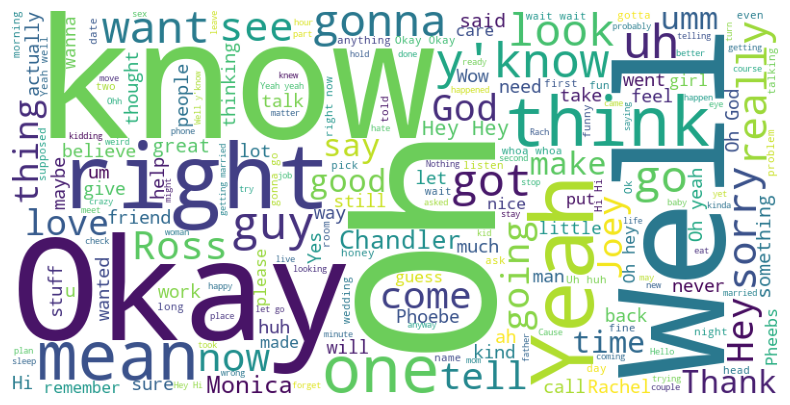

In [8]:
create_wordcloud(df, my_class_index='utterances')


#### Defining same useful variables 

In [9]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
TRIGGERS = np.unique([item for sublist in df["triggers"] for item in sublist])

EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

EMOTIONS_TO_IDX


{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

### Taking a look to same utterance example

In [10]:
display_dialogue(dataframe=df.drop(columns='speaker_and_utterances'), utterance_id='utterance_6')
display_dialogue(dataframe=df.drop(columns='speaker_and_utterances'), utterance_id='utterance_456')
display_dialogue(dataframe=df.drop(columns='speaker_and_utterances'), utterance_id='utterance_2005')

### Removing NaN Values

Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Analyzing the dataset

In [11]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in a dialog: {speakers['min_speakers']}")
print(f"Maximum number of speakers in a dialog: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in a dialog: {utterances['length_min']}")
print(f"Maximum number of sentences in a dialog: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in a dialog: 1
Maximum number of speakers in a dialog: 8

Minimum number of sentences in a dialog: 2
Maximum number of sentences in a dialog: 24


In [12]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


### Appling some preprocessing operations 


### Splitting the dataset 

In [13]:
train_df, val_df, test_df = split_dataset(df)

print("Training Set: ")
display(train_df.head())

print("\nValidation Set: ")
display(val_df.head())

print("\nTest Set: ")
display(test_df.head())


Training Set: 


,speakers,emotions,utterances,triggers,speaker_and_utterances
index,,,,,
utterance_900,"[Chandler, Julie, Chandler]","[joy, neutral, neutral]","[Julie hi! Chandler Bing, I, I guess you remem...","[0.0, 1.0, 0.0]","[Chandler: Julie hi! Chandler Bing, I, I guess..."
utterance_304,"[Joey, Monica, Joey, Monica, Joey, Phoebe, Mon...","[neutral, neutral, neutral, joy, fear, neutral...","[OK, you've got to promise that you'll never, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Joey: OK, you've got to promise that you'll n..."
utterance_2568,"[Monica, Rachel, Rachel]","[joy, anger, sadness]","[Noooo! I'm lying. I am so drunk., Oh God, oh...","[1.0, 0.0, 0.0]","[Monica: Noooo! I'm lying. I am so drunk., Ra..."
utterance_2895,"[Rachel, Rachel, Rachel, Rachel, Stranger, Rac...","[sadness, sadness, fear, neutral, neutral, joy...","[Mom, would you relax., That was 10 blocks fro...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[Rachel: Mom, would you relax., Rachel: That w..."
utterance_287,"[Ross, Rachel, Phoebe, Phoebe]","[joy, anger, anger, neutral]","[Ah-ha, nowhere to run!, I don't like sitting ...","[0.0, 0.0, 0.0, 0.0]","[Ross: Ah-ha, nowhere to run!, Rachel: I don't..."



Validation Set: 


,speakers,emotions,utterances,triggers,speaker_and_utterances
index,,,,,
utterance_1398,"[Chandler, Joey, Chandler]","[anger, neutral, joy]","[You win., Well, what did you have?, It doesn'...","[0.0, 0.0, 0.0]","[Chandler: You win., Joey: Well, what did you ..."
utterance_2257,"[Monica, Angela, Monica, Angela, Monica]","[joy, joy, joy, joy, surprise]","[I've gotta tell you, Bob is terrific., Yeah, ...","[0.0, 0.0, 0.0, 1.0, 0.0]","[Monica: I've gotta tell you, Bob is terrific...."
utterance_2582,"[Joey, Ross, Joey, Ross, Ross, Ross, Joey, Ros...","[neutral, neutral, neutral, neutral, neutral, ...",[Note the painterly lines and subtle impast...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Joey: Note the painterly lines and subtle ...
utterance_3366,"[Ross, Joey, Ross, Emily, Ross, Emily, Ross, E...","[sadness, anger, anger, anger, neutral, neutra...","[What? No! No, I'm not stopping. I'm Red Ross!...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[Ross: What? No! No, I'm not stopping. I'm Red..."
utterance_1365,"[Ross, Emily, Emily]","[surprise, neutral, sadness]","[Hello?, Ross., It was dreadful. I felt terrib...","[0.0, 0.0, 0.0]","[Ross: Hello?, Emily: Ross., Emily: It was dre..."



Test Set: 


,speakers,emotions,utterances,triggers,speaker_and_utterances
index,,,,,
utterance_148,"[Kate, Joey, Joey, Joey, Joey, Joey, Joey, The...","[anger, anger, surprise, anger, anger, anger, ...",[Happy?! Is that what I'm supposed to be Vic? ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Kate: Happy?! Is that what I'm supposed to be...
utterance_1786,"[Ross, Tag, Tag, Ross, Tag, Ross, Tag]","[joy, joy, neutral, neutral, surprise, surpris...","[Hey! How you doing?, Good! Good, long time no...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[Ross: Hey! How you doing?, Tag: Good! Good, l..."
utterance_42,"[Chandler, Jade, Jade, Chandler, Ross, Chandle...","[neutral, neutral, neutral, joy, neutral, neut...","[What've you been up to?, Oh, you know, the us...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Chandler: What've you been up to?, Jade: Oh, ..."
utterance_2913,"[Phoebe, Phoebe, Phoebe, Phoebe]","[neutral, neutral, anger, neutral]","[Crew guy., Yeah., Why have you been following...","[0.0, 0.0, 1.0, 1.0]","[Phoebe: Crew guy., Phoebe: Yeah., Phoebe: Why..."
utterance_2194,"[Chandler, Monica, Monica]","[anger, sadness, neutral]","[I can't believe I did this! What an idiot!, O...","[1.0, 0.0, 1.0]",[Chandler: I can't believe I did this! What an...


### Visualizing the classes distribution over the datasets

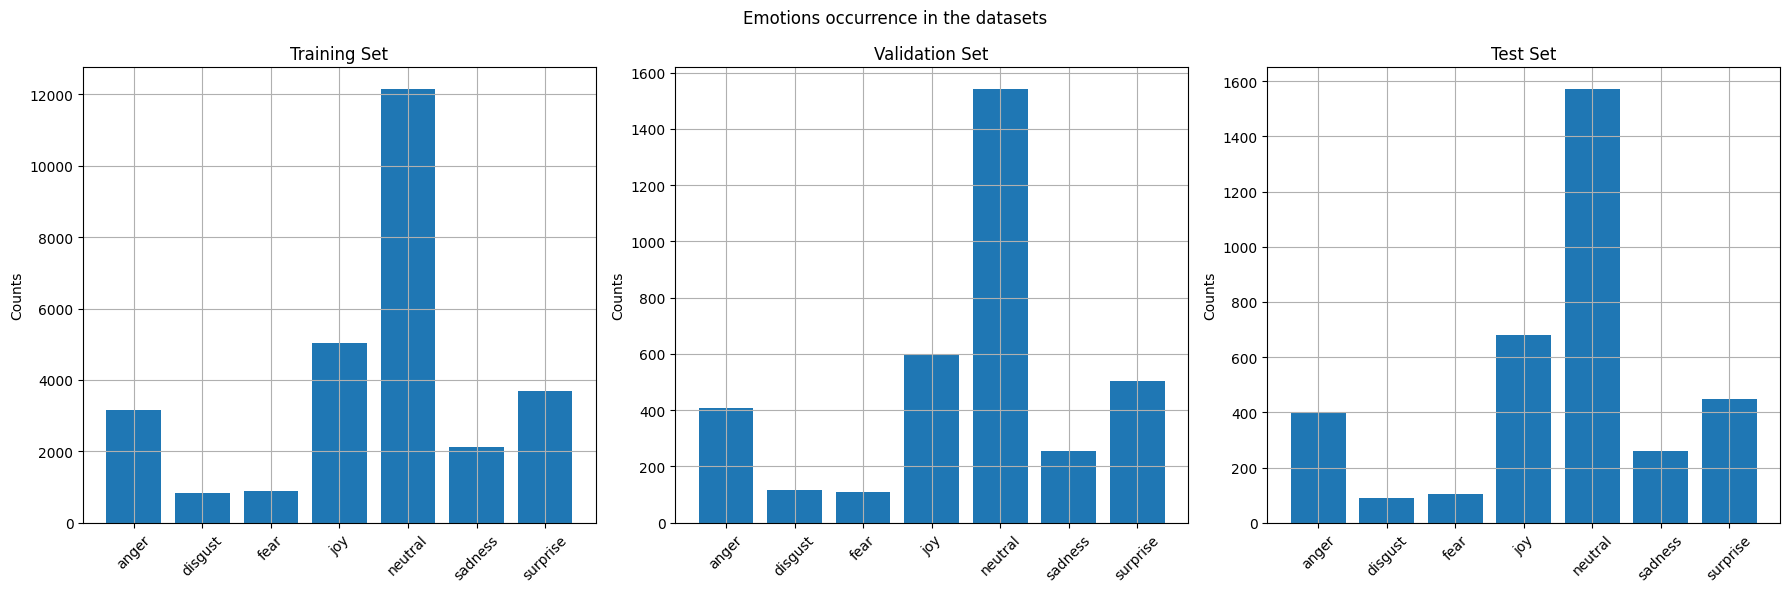

In [14]:
plot_emotion_distribution(train_df, val_df, test_df)


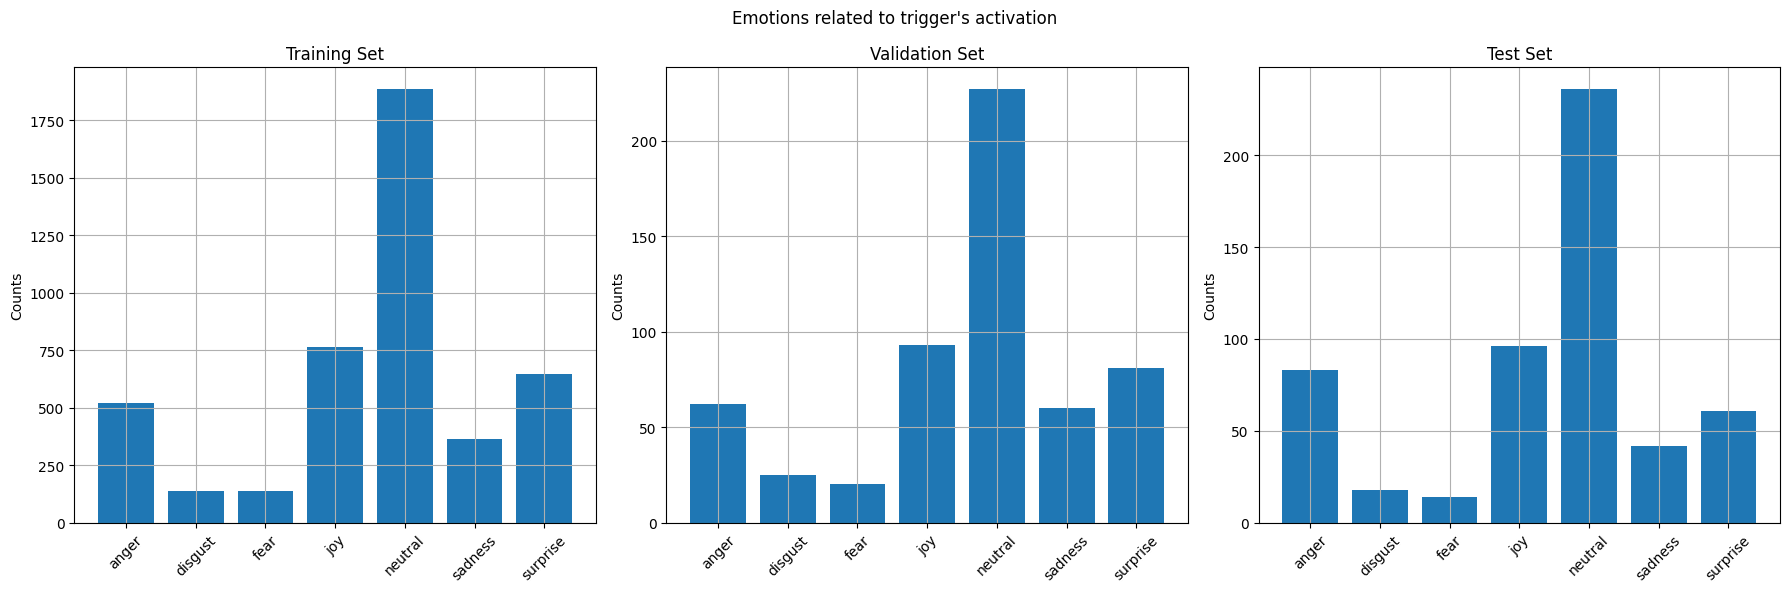

In [15]:
# How many times each emotion activates a trigger
plot_triggers_per_emotion(train_df, val_df, test_df)


### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [16]:
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion]for emotion in df['emotions'].sum()])
emotion_weights = np.append(emotion_weights, 0)

trigger_weights = create_classes_weights(df['triggers'].sum())
trigger_weights = np.append(trigger_weights, 0)

padded_emotions = list(EMOTIONS) + ['z_emotion']    
padded_triggers = list(TRIGGERS) + [2]

print('Emotion weights')
display(pd.DataFrame({'Emotion': padded_emotions, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': padded_triggers, 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426
7,z_emotion,0.000000


Trigger weights


,Trigger,Weight
0,0.0,0.594761
1,1.0,3.138206
2,2.0,0.000000


## Random Classifier

In [17]:
# todo metric computation
if RUN_RANDOM_CLF:

    emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
    random_classifier = RandomClassifier(emotions)
    
    pred_emotions, pred_triggers = random_classifier.predict(test_df)
    
    # esempio di print per gli scettici che non crederanno che il classifier funziona
    
    new_test_df = test_df.copy()
    new_test_df['pred_emotions'] = pred_emotions
    new_test_df['pred_triggers'] = pred_triggers
    display_dialogue(dataframe=new_test_df.drop(columns='speaker_and_utterances'), utterance_id=0)  


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Kate,anger,Happy?! Is that what I'm supposed to be Vic? H...,0.0,anger,1
1,Joey,anger,"Well, why don't you tell me what you're suppos...",0.0,disgust,0
2,Joey,surprise,Huh?,0.0,anger,1
3,Joey,anger,Because I sure as hell can't figure it out!,0.0,neutral,0
4,Joey,anger,I talk to you and nothin'.,0.0,joy,0
5,Joey,anger,"You look at me, and it's nothin'.",0.0,anger,0
6,Joey,anger,Nothing.,0.0,sadness,0
7,The Director,joy,Tasty! I'm really starting to feel like you gu...,0.0,sadness,0
8,Kate,neutral,I have a question about this scene.,0.0,anger,1
9,The Director,neutral,Yes?,0.0,disgust,0


## Majority Classifier

In [18]:
# todo metrics computation
if RUN_MAJORITY_CLF:
    majority_classifier = MajorityClassifier()
    
    majority_classifier.fit(train_df)
    pred_emotions, pred_triggers = majority_classifier.predict(test_df)
    
    # esempio di print per gli scettici che non crederanno che il classifier funziona
    new_test_df = test_df.copy()
    new_test_df['pred_emotions'] = pred_emotions
    new_test_df['pred_triggers'] = pred_triggers
    display_dialogue(dataframe=new_test_df, utterance_id=0)


Utterance_0


,speakers,emotions,utterances,triggers,speaker_and_utterances,pred_emotions,pred_triggers
0,Kate,anger,Happy?! Is that what I'm supposed to be Vic? H...,0.0,Kate: Happy?! Is that what I'm supposed to be ...,neutral,0.0
1,Joey,anger,"Well, why don't you tell me what you're suppos...",0.0,"Joey: Well, why don't you tell me what you're ...",neutral,0.0
2,Joey,surprise,Huh?,0.0,Joey: Huh?,neutral,0.0
3,Joey,anger,Because I sure as hell can't figure it out!,0.0,Joey: Because I sure as hell can't figure it out!,neutral,0.0
4,Joey,anger,I talk to you and nothin'.,0.0,Joey: I talk to you and nothin'.,neutral,0.0
5,Joey,anger,"You look at me, and it's nothin'.",0.0,"Joey: You look at me, and it's nothin'.",neutral,0.0
6,Joey,anger,Nothing.,0.0,Joey: Nothing.,neutral,0.0
7,The Director,joy,Tasty! I'm really starting to feel like you gu...,0.0,The Director: Tasty! I'm really starting to fe...,neutral,0.0
8,Kate,neutral,I have a question about this scene.,0.0,Kate: I have a question about this scene.,neutral,0.0
9,The Director,neutral,Yes?,0.0,The Director: Yes?,neutral,0.0


## Bert Models

In [19]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


#### Data Loaders creation

In [20]:
dataLoaderBuilder = DataLoaderFromPipelineStrategy()

max_tokenized_length = find_max_encoded_utterance(bert_tokenizer, df['utterances'])
my_tokenization_f = partial(tokenize_data, max_tokenized_length=max_tokenized_length, tokenizer=bert_tokenizer)

  
# BertFreezed Dataloaders
train_dataloader_freezed = dataLoaderBuilder.create(data=train_df["utterances"],
                                                    labels=train_df[["emotions", "triggers"]],
                                                    shuffle=True,
                                                    data_preprocess_f=my_tokenization_f,
                                                    labels_preprocess_f=preprocess_labels,
                                                    batch_size=32,
                                                    device=device)
 
val_dataloader_freezed = dataLoaderBuilder.create(data=val_df["utterances"],
                                                  labels=val_df[["emotions", "triggers"]],
                                                  shuffle=False,
                                                  data_preprocess_f=my_tokenization_f,
                                                  labels_preprocess_f=preprocess_labels,
                                                  batch_size=32,
                                                  device=device)
 
test_dataloader_freezed = dataLoaderBuilder.create(data=test_df["utterances"],
                                                   labels=test_df[["emotions", "triggers"]],
                                                   shuffle=False,
                                                   data_preprocess_f=my_tokenization_f,
                                                   labels_preprocess_f=preprocess_labels,
                                                   batch_size=32,
                                                   device=device)   


# BertFull Dataloaders
train_dataloader_full = dataLoaderBuilder.create(data=train_df["utterances"],
                                                 labels=train_df[["emotions", "triggers"]],
                                                 shuffle=True,
                                                 data_preprocess_f=my_tokenization_f,
                                                 labels_preprocess_f=preprocess_labels,
                                                 batch_size=2,
                                                 device=device)
 
val_dataloader_full = dataLoaderBuilder.create(data=val_df["utterances"],
                                               labels=val_df[["emotions", "triggers"]],
                                               shuffle=False,
                                               data_preprocess_f=my_tokenization_f,
                                               labels_preprocess_f=preprocess_labels,
                                               batch_size=2,
                                               device=device)
 
test_dataloader_full = dataLoaderBuilder.create(data=test_df["utterances"],
                                                labels=test_df[["emotions", "triggers"]],
                                                shuffle=False,
                                                data_preprocess_f=my_tokenization_f,
                                                labels_preprocess_f=preprocess_labels,
                                                batch_size=2,
                                                device=device)  
 
input_data_freezed, _ = next(iter(train_dataloader_freezed))
input_data_full, _ = next(iter(train_dataloader_full))

n_token_per_utterance = input_data_freezed['input_ids'].shape[-1]


### Defining Metrics and Criterion

In [21]:
emotion_weight = 1
trigger_weight = 0.375

#Losses definitions and combination
emotion_criterion = Criterion(name='emotion_cross_entropy', 
                              loss_function=torch.nn.CrossEntropyLoss(reduction='none'))  # weight=torch.tensor(emotion_weights)

trigger_criterion = Criterion(name='trigger_cross_entropy', 
                              loss_function=torch.nn.CrossEntropyLoss(reduction='none'))  # weight=torch.tensor(trigger_weights)

multi_head_criterion = MultyHeadCriterion(name='agg_CE_loss',
                                          loss_functions={'emotions': emotion_criterion, 
                                                          'triggers': trigger_criterion},
                                          loss_weights=[emotion_weight, trigger_weight],
                                          reduction_function=torch.mean)


##### Metrics definitions and combination

# F1 definition
emotion_f1 = F1_Score(name='emotion_F1',
                      mode='macro',
                      num_classes=len(padded_emotions),
                      classes_to_exclude=[8])     

trigger_f1 = F1_Score(name='triggers_F1',
                      mode='macro',
                      num_classes=len(padded_triggers),
                      classes_to_exclude=[2])     

multi_head_f1 = MultyHeadMetric(name='agg_avg_F1',
                                metrics_functions={'emotions': emotion_f1,
                                                   'triggers': trigger_f1},
                                metric_weights=[emotion_weight, trigger_weight],
                                aggregate_metrics_function=torch.mean)


# Accuracy definition
emotion_accuracy = Accuracy(name='emotion_accuracy',
                            num_classes=len(padded_emotions),
                            classes_to_exclude=[8])     

trigger_accuracy = Accuracy(name='triggers_accuracy',
                            num_classes=len(padded_triggers),
                            classes_to_exclude=[2])     

multi_head_accuracy = MultyHeadMetric(name='agg_avg_accuracy',
                                      metrics_functions={'emotions': emotion_accuracy,
                                                         'triggers': trigger_accuracy},
                                      metric_weights=[emotion_weight, trigger_weight],
                                      aggregate_metrics_function=torch.mean)


# Recall definition
emotion_recall = Recall(name='emotion_recall',
                        num_classes=len(padded_emotions),
                        classes_to_exclude=[8])     

trigger_recall = Recall(name='triggers_recall',
                        num_classes=len(padded_triggers),
                        classes_to_exclude=[2])     

multi_head_recall = MultyHeadMetric(name='agg_avg_recall',
                                    metrics_functions={'emotions': emotion_recall,
                                                       'triggers': trigger_recall},
                                    metric_weights=[emotion_weight, trigger_weight],
                                    aggregate_metrics_function=torch.mean)


# Precision definition
emotion_precision = Precision(name='emotion_precision',
                              num_classes=len(padded_emotions),
                              classes_to_exclude=[8])     

trigger_precision = Precision(name='triggers_precision',
                              num_classes=len(padded_triggers),
                              classes_to_exclude=[2])     
      
multi_head_precision = MultyHeadMetric(name='agg_avg_precision',
                                       metrics_functions={'emotions': emotion_precision,
                                                          'triggers': trigger_precision},
                                       metric_weights=[emotion_weight, trigger_weight],
                                       aggregate_metrics_function=torch.mean)
   


optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                             identifier=f'lr={1e-5}', 
                             optimizer_partial_params={'lr': 1e-5})  

early_stopper = EarlyStopper(monitor='agg_CE_loss', 
                             patience=PATIENCE, 
                             delta=0, 
                             mode='min',
                             restore_weights=True)
        

### Freezed Bert

#### Grid Search Freezed BertOne 

In [22]:
#todo grid 

#### Creating Freezed BertOne

In [23]:
torch.manual_seed(42)
np.random.seed(42)

freezed_bert = BertOne(bert_model=bert_model,
                       n_emotions=len(padded_emotions),
                       n_triggers=len(padded_triggers),
                       cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                       freeze_bert_weights=True).to(device)



####   Visualizing Net Structure 

In [24]:
freezed_bert.visualize_network_graph(input=input_data_freezed, 
                                     input_names=['tokenized utterances', 'token id', 'attention mask'],
                                     output_names=['emotions,triggers'])


#### Visualizing the summary 

In [25]:
freezed_bert.summary(input_data_freezed, verbose=True)


--------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1             [32, 380, 768]      23,440,896
              Embedding-2             [32, 380, 768]           1,536
              Embedding-3             [32, 380, 768]         393,216
              LayerNorm-4             [32, 380, 768]           1,536
                Dropout-5             [32, 380, 768]               0
         BertEmbeddings-6             [32, 380, 768]               0
                 Linear-7             [32, 380, 768]         590,592
                 Linear-8             [32, 380, 768]         590,592
                 Linear-9             [32, 380, 768]         590,592
               Dropout-10         [32, 12, 380, 380]               0
     BertSelfAttention-11           [[-1, 380, 768]]               0
                Linear-12             [32, 380, 768]         590,592
               Dropout-13         

#### Fitting Freezed BertOne

In [26]:
if FIT_FREEZED_BERTONE:

    freezed_bert_history = freezed_bert.fit(train_loader=train_dataloader_freezed,
                                              val_loader=val_dataloader_freezed,
                                              criterion=multi_head_criterion,
                                              metrics=[multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                              optimizer=optimizer,
                                              early_stopper=early_stopper,
                                              num_epochs=15)
        
    torch.save(freezed_bert.state_dict(), FREEZED_BERTONE_WEIGHTS_PATH)

else:
    freezed_bert.load_state_dict(torch.load(FREEZED_BERTONE_WEIGHTS_PATH))
    freezed_bert_history = None
    

 Epoch: 1/15 Iterations: 100/100 Time: 730.877s - agg_CE_loss: 8.032481879773126 - agg_avg_F1: 0.261273925320263 - emotion_F1: 0.30896897280844 - triggers_F1: 0.569543674218896 - agg_avg_accuracy: 0.492612690768179 - emotion_accuracy: 0.691653645833333 - triggers_accuracy: 0.782857961874731 - agg_avg_recall: 0.492612690768179 - emotion_recall: 0.691653645833333 - triggers_recall: 0.782857961874731 - agg_avg_precision: 0.492612690768179 - emotion_precision: 0.691653645833333 - triggers_precision: 0.782857961874731 - val_agg_CE_loss: 8.055356526755812 - val_agg_avg_F1: 0.257693787264163 - val_emotion_F1: 0.307679586892463 - val_triggers_F1: 0.553887967028969 - val_agg_avg_accuracy: 0.490244583805076 - val_emotion_accuracy: 0.691145833333333 - val_triggers_accuracy: 0.771582224738183 - val_agg_avg_recall: 0.490244583805076 - val_emotion_recall: 0.691145833333333 - val_triggers_recall: 0.771582224738183 - val_agg_avg_precision: 0.490244583805076 - val_emotion_precision: 0.691145833333333 -

#### Visualizing training history  

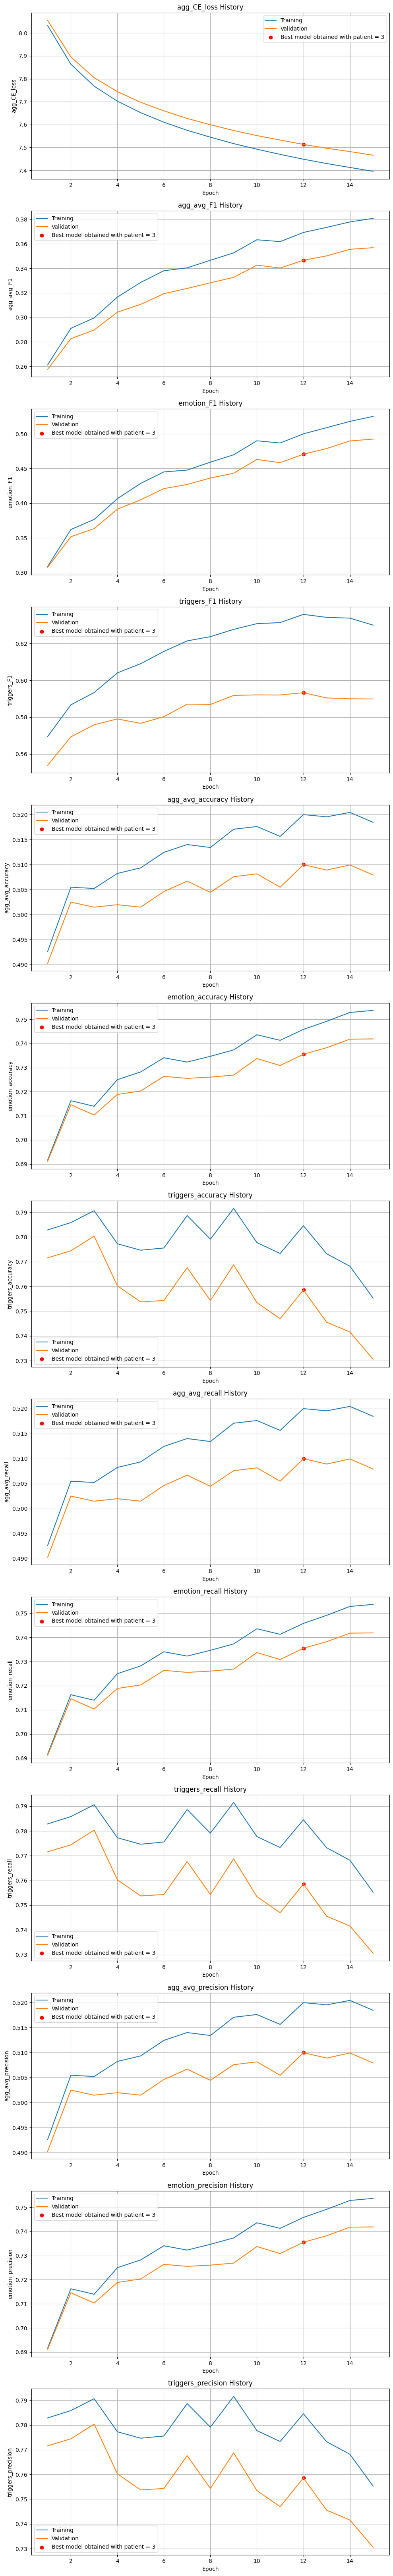

In [27]:
if FIT_FREEZED_BERTONE:
    plot_history(freezed_bert_history, patience=PATIENCE)
else:
    print("To show the training history of Freezed BERT base model  you should set the flag FIT_FREEZED_BERTONE=True ")
    

### Full Bert

#### Grid Search Full BertOne 

In [28]:
# todo grid search

#### Creating Full BertOne

In [29]:
full_bert = BertOne(bert_model=bert_model,
                    n_emotions=len(padded_emotions),
                    n_triggers=len(padded_triggers),
                    cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                    freeze_bert_weights=False).to(device)

#### Visualizing the summary 

In [30]:
full_bert.summary(input_data_full, verbose=True)


--------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1              [2, 380, 768]      23,440,896
              Embedding-2              [2, 380, 768]           1,536
              Embedding-3              [2, 380, 768]         393,216
              LayerNorm-4              [2, 380, 768]           1,536
                Dropout-5              [2, 380, 768]               0
         BertEmbeddings-6              [2, 380, 768]               0
                 Linear-7              [2, 380, 768]         590,592
                 Linear-8              [2, 380, 768]         590,592
                 Linear-9              [2, 380, 768]         590,592
               Dropout-10          [2, 12, 380, 380]               0
     BertSelfAttention-11           [[-1, 380, 768]]               0
                Linear-12              [2, 380, 768]         590,592
               Dropout-13         

#### Fitting Freezed BertOne

In [31]:
if FIT_FULL_BERTONE:

    full_bert_history = full_bert.fit(train_loader=train_dataloader_full,
                                      val_loader=val_dataloader_full,
                                      criterion=multi_head_criterion,
                                      metrics=[multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                      optimizer=optimizer,
                                      early_stopper=early_stopper,
                                      num_epochs=15)
        
    torch.save(full_bert.state_dict(), FULL_BERTONE_WEIGHTS_PATH)

else:
    full_bert.load_state_dict(torch.load(FULL_BERTONE_WEIGHTS_PATH))
    full_bert_history = None
        

 Epoch: 1/15 Iterations: 1600/1600 Time: 754.963s - agg_CE_loss: 7.610160292118883 - agg_avg_F1: 0.331732530838244 - emotion_F1: 0.434187772778897 - triggers_F1: 0.611406103726913 - agg_avg_accuracy: 0.513259690135146 - emotion_accuracy: 0.734049479166667 - triggers_accuracy: 0.779919736276336 - agg_avg_recall: 0.513259690135146 - emotion_recall: 0.734049479166667 - triggers_recall: 0.779919736276336 - agg_avg_precision: 0.513259690135146 - emotion_precision: 0.734049479166667 - triggers_precision: 0.779919736276336 - val_agg_CE_loss: 7.65638643745079 - val_agg_avg_F1: 0.311126685029026 - val_emotion_F1: 0.405735657426077 - val_triggers_F1: 0.577380567018597 - val_agg_avg_accuracy: 0.505475369138598 - val_emotion_accuracy: 0.724791666666667 - val_triggers_accuracy: 0.763090857628078 - val_agg_avg_recall: 0.505475369138598 - val_emotion_recall: 0.724791666666667 - val_triggers_recall: 0.763090857628078 - val_agg_avg_precision: 0.505475369138598 - val_emotion_precision: 0.724791666666667

#### Visualizing training history  

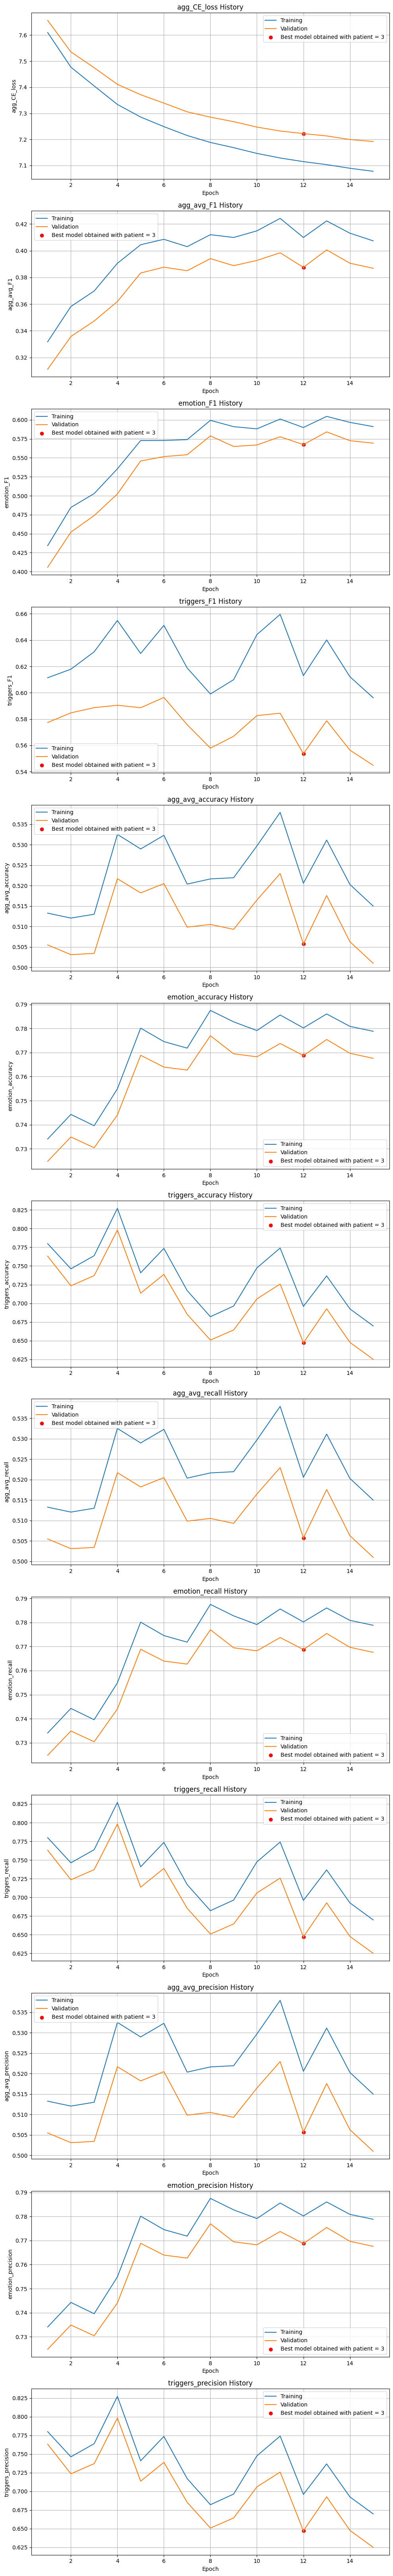

In [32]:
if FIT_FULL_BERTONE:
    plot_history(full_bert_history, patience=PATIENCE)
else:
    print("To show the training history of Full BERT base model  you should set the flag FIT_FULL_BERTONE=True ")

## Further experiments

### Dataloaders creation

In [33]:
max_tokenized_length_su = find_max_encoded_utterance(bert_tokenizer, df['speaker_and_utterances'])
my_tokenization_f_su = partial(tokenize_data, max_tokenized_length=max_tokenized_length_su, tokenizer=bert_tokenizer)

# BertFreezed Dataloaders
train_dataloader_freezed_su = dataLoaderBuilder.create(data=train_df["speaker_and_utterances"],
                                                       labels=train_df[["emotions", "triggers"]],
                                                       shuffle=True,
                                                       data_preprocess_f=my_tokenization_f_su,
                                                       labels_preprocess_f=preprocess_labels,
                                                       batch_size=32,
                                                       device=device)
 
val_dataloader_freezed_su = dataLoaderBuilder.create(data=val_df["speaker_and_utterances"],
                                                     labels=val_df[["emotions", "triggers"]],
                                                     shuffle=False,
                                                     data_preprocess_f=my_tokenization_f_su,
                                                     labels_preprocess_f=preprocess_labels,
                                                     batch_size=32,
                                                     device=device)
 
test_dataloader_freezed_su = dataLoaderBuilder.create(data=test_df["speaker_and_utterances"],
                                                      labels=test_df[["emotions", "triggers"]],
                                                      shuffle=False,
                                                      data_preprocess_f=my_tokenization_f_su,
                                                      labels_preprocess_f=preprocess_labels,
                                                      batch_size=32,
                                                      device=device)


# BertFull Dataloaders
train_dataloader_full_su = dataLoaderBuilder.create(data=train_df["speaker_and_utterances"],
                                                    labels=train_df[["emotions", "triggers"]],
                                                    shuffle=True,
                                                    data_preprocess_f=my_tokenization_f_su,
                                                    labels_preprocess_f=preprocess_labels,
                                                    batch_size=2,
                                                    device=device)
 
val_dataloader_full_su = dataLoaderBuilder.create(data=val_df["speaker_and_utterances"],
                                                  labels=val_df[["emotions", "triggers"]],
                                                  shuffle=False,
                                                  data_preprocess_f=my_tokenization_f_su,
                                                  labels_preprocess_f=preprocess_labels,
                                                  batch_size=2,
                                                  device=device)
 
test_dataloader_full_su = dataLoaderBuilder.create(data=test_df["speaker_and_utterances"],
                                                   labels=test_df[["emotions", "triggers"]],
                                                   shuffle=False,
                                                   data_preprocess_f=my_tokenization_f_su,
                                                   labels_preprocess_f=preprocess_labels,
                                                   batch_size=2,
                                                   device=device)


input_data_freezed_su, _ = next(iter(train_dataloader_freezed_su))
input_data_full_su, _ = next(iter(train_dataloader_full_su))

n_token_per_utterance_su = input_data_freezed_su['input_ids'].shape[-1]

In [34]:
# todo inserire i test aggiungendo gli speaker
# todo aggiungere i test mettendo i linear layer aggiuntivi
# todo aggiungere tutti i test del mondo